# HW1-2: Model Inference of the Pretrained LeNet

<font color='red'>Name: 徐義鈞 Student ID: 113062575 </font>

## 0. Initial Setup
* Currently, Numba does not support Python 3.10 or higher versions. Therefore, if you are using Python versions 3.10 and above, **please downgrade to a lower version or switch to running it on Colab**
* If errors occur, it may be due to incompatibility between the versions of NumPy and Numba. You can try adding `!pip install numpy==1.18`. If the issue persists, consider switching to running it on Colab.

In [1]:
#Uncomment the following line if you are on your local machine and facing issues with numpy. Comment it if you are on colab
#!pip install numpy==1.18
# !sudo apt-get update -y
# !sudo apt-get install python3.8
# !sudo update-alternatives --install /usr/local/bin/python3 python3 /usr/bin/python3.8 2
# !sudo update-alternatives --config python3
# !pip install numba==0.55.1

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,374 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [69.0 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu 

In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import json
import numpy as np
from functional import *

## 1. High-level Function Implementation for Each Layer
Implement a high-level functional model for each layer of the CNN, including convolution, pooling, and
fully-connected layer with 8-bit quantization of the input activations, output activations, and weights accordingly.
* Learn how to use [Numba](https://numba.pydata.org/) to accelerate python functions
* Fill in the TODOs in `functional.py`.
    * You must consider `psum_range = (lower_bound, upper_bound)` which controls the precision of partial sums. That means the accumulation of activations will not exceed this range during the process of computing convolution and fully-connected layers.
    * `psum_record_list` will be used in *2. Bit-width of Partial Sums*, so you may leave it alone for now.
    
### 1.1 Pass all Unit Tests of `OpTestCase`.
First, use 32-bit signed integers for the partial sums to pass the unit tests. The accumulation of activations is limited to 32 bits in convolution and fully-connected layers. Clamp the value if it exceeds the minimum or maximum values of the 32-bit signed number.

Note that you should implement convolution layers, fully-connected layers, and max-pooling layers with "nested loops" by yourself. You are not allowed to use existing functions (e.g., `conv2d` in `numpy` or `pytorch`). Or you will not get any credits. Raise questions when in doubt.

There are eight unit tests you need to pass. If you intend to run part of them, follow the steps:
```
tests = ['test_C1', 'test_C3']
suite = unittest.TestSuite(map(OpTestCase, tests))
```

In [3]:
#unzip parameters.zip if needed
!unzip parameters.zip

Archive:  parameters.zip
  inflating: weights/conv1.conv.weight.csv  
  inflating: weights/conv3.conv.weight.csv  
  inflating: weights/conv5.conv.weight.csv  
  inflating: weights/fc6.fc.weight.csv  
  inflating: weights/output.fc.weight.csv  
  inflating: fixed_scale.json        
  inflating: weights/output.fc.bias.csv  
  inflating: activations/img0/input.csv  
  inflating: activations/img0/output.csv  
  inflating: activations/img0/conv1/input.csv  
  inflating: activations/img0/conv1/output.csv  
  inflating: activations/img0/maxpool2/input.csv  
  inflating: activations/img0/maxpool2/output.csv  
  inflating: activations/img0/conv3/input.csv  
  inflating: activations/img0/conv3/output.csv  
  inflating: activations/img0/maxpool4/input.csv  
  inflating: activations/img0/maxpool4/output.csv  
  inflating: activations/img0/conv5/input.csv  
  inflating: activations/img0/conv5/output.csv  
  inflating: activations/img0/fc6/input.csv  
  inflating: activations/img0/fc6/output.csv  


In [4]:
import unittest

class OpTestCase(unittest.TestCase):

    def setUp(self):
        bit = 32
        self.number_range = (-(2**(bit-1)), 2**(bit-1) - 1)
        self.weightsDict, self.scalesDict = getWeightAndScale()
        self.max_samples = 100 #100


    def tearDown(self):
        self.weightsDict, self.scalesDict = None, None
        self.source = None

    def test_C1(self):
        for i in range(self.max_samples):
            self.source = "./activations/img{}/".format(i)
            x = np.loadtxt(self.source+"/conv1/input.csv", delimiter=',').astype(int)
            x = x.reshape(1, 1, 32, 32)
            x, _ = Conv2d(self.number_range, x, self.weightsDict["conv1.conv"], out_channels=6)
            x = x.flatten()
            x_ = np.loadtxt(self.source+"/conv1/output.csv", delimiter=',').astype(int)
            self.assertTrue(np.all(x == x_))

    def test_ACTQUANT(self):
        for i in range(self.max_samples):
            self.source = "./activations/img{}/".format(i)
            x = np.loadtxt(self.source+"/conv1/output.csv", delimiter=',').astype(int)
            x = ActQuant(x, self.scalesDict["conv1.conv"])
            x = ReLU(x).flatten()
            x_ = np.loadtxt(self.source+"/maxpool2/input.csv", delimiter=',').astype(int)
            self.assertTrue(np.all(x == x_))

    def test_S2(self):
        for i in range(self.max_samples):
            self.source = "./activations/img{}/".format(i)
            x = np.loadtxt(self.source+"/maxpool2/input.csv", delimiter=',').astype(int)
            x = x.reshape(1, 6, 28, 28)
            x = MaxPool2d(x).flatten()
            x_ = np.loadtxt(self.source+"/maxpool2/output.csv", delimiter=',').astype(int)
            self.assertTrue(np.all(x == x_))

    def test_C3(self):
        for i in range(self.max_samples):
            self.source = "./activations/img{}/".format(i)
            x = np.loadtxt(self.source+"/conv3/input.csv", delimiter=',').astype(int)
            x = x.reshape(1, 6, 14, 14)
            x, _ = Conv2d(self.number_range, x, self.weightsDict["conv3.conv"], out_channels=16)
            x = x.flatten()
            x_ = np.loadtxt(self.source+"/conv3/output.csv", delimiter=',').astype(int)
            self.assertTrue(np.all(x == x_))

    def test_S4(self):
        for i in range(self.max_samples):
            self.source = "./activations/img{}/".format(i)
            x = np.loadtxt(self.source+"/maxpool4/input.csv", delimiter=',').astype(int)
            x = x.reshape(1, 16, 10, 10)
            x = MaxPool2d(x).flatten()
            x_ = np.loadtxt(self.source+"/maxpool4/output.csv", delimiter=',').astype(int)
            self.assertTrue(np.all(x == x_))

    def test_C5(self):
        for i in range(self.max_samples):
            self.source = "./activations/img{}/".format(i)
            x = np.loadtxt(self.source+"/conv5/input.csv", delimiter=',').astype(int)
            x = x.reshape(1, 16, 5, 5)
            x, _ = Conv2d(self.number_range, x, self.weightsDict["conv5.conv"], out_channels=120)
            x = x.flatten()
            x_ = np.loadtxt(self.source+"/conv5/output.csv", delimiter=',').astype(int)
            self.assertTrue(np.all(x == x_))

    def test_F6(self):
        for i in range(self.max_samples):
            self.source = "./activations/img{}/".format(i)
            x = np.loadtxt(self.source+"/fc6/input.csv", delimiter=',').astype(int)
            x = x.reshape(1, 120)
            x, _ = Linear(self.number_range, x, self.weightsDict["fc6.fc"])
            x_ = np.loadtxt(self.source+"/fc6/output.csv", delimiter=',')
            self.assertTrue(np.all(x == x_))

    def test_OUTPUT(self):
        for i in range(1,self.max_samples):
            self.source = "./activations/img{}/".format(i)
            x = np.loadtxt(self.source+"/output/input.csv", delimiter=',').astype(int)
            x = x.reshape(1, 84)
            x, _ = Linear(self.number_range, x, self.weightsDict["output.fc"], self.weightsDict["outputBias"])
            x_ = np.loadtxt(self.source+"/output/output.csv", delimiter=',')
            self.assertTrue(np.all(x == x_))


In [5]:
# tests = ['test_OUTPUT']
# suite = unittest.TestSuite(map(OpTestCase, tests))
suite = unittest.TestLoader().loadTestsFromTestCase(OpTestCase)
unittest.TextTestRunner(verbosity=2).run(suite)

test_ACTQUANT (__main__.OpTestCase.test_ACTQUANT) ... ok
test_C1 (__main__.OpTestCase.test_C1) ... ok
test_C3 (__main__.OpTestCase.test_C3) ... ok
test_C5 (__main__.OpTestCase.test_C5) ... ok
test_F6 (__main__.OpTestCase.test_F6) ... ok
test_OUTPUT (__main__.OpTestCase.test_OUTPUT) ... ok
test_S2 (__main__.OpTestCase.test_S2) ... ok
test_S4 (__main__.OpTestCase.test_S4) ... ok

----------------------------------------------------------------------
Ran 8 tests in 8.051s

OK


<unittest.runner.TextTestResult run=8 errors=0 failures=0>

### 1.2 Reconstruct the LeNet in HW1
* Fill in the TODO in `forward()` of `LeNet` in `functional.py`.
* Test the model with the test dataset. There should be no accuracy degradation if you have done everything correctly.

In [6]:
def test(model, dataloader: DataLoader, max_samples=None):
    cnt = 0
    total = 0
    n_inferences = 0
    for i, data in enumerate(dataloader):

        images, labels = data[0].numpy(), data[1].numpy()
        y = model.forward(images)

        y = np.argmax(y, axis=1)
        cnt = cnt + np.count_nonzero((labels == y) == True)
        total += images.shape[0]

        if max_samples:
            n_inferences += images.shape[0]
            if n_inferences >= max_samples:
                break

    print("Accuracy: {}%".format(cnt/total*100))
    return cnt/total*100

In [7]:
transform = transforms.Compose(
    [
     transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))
    ])

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
def run_LeNet(n_bit, max_samples = None):
    number_range = (-(2**(n_bit-1)), 2**(n_bit-1) - 1)
    print("bit:", n_bit)
    print("bit-width range:",number_range)

    psum_range = {
        'c1': number_range,
        'c3': number_range,
        'c5': number_range,
        'f6': number_range,
        'output': number_range
    }

    model = LeNet(psum_range)

    return test(model, testloader)

run_LeNet(n_bit = 32)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.03MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.30MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.33MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

bit: 32
bit-width range: (-2147483648, 2147483647)


Accuracy: 98.58%


98.58

## 2. Bit-width of Partial Sums
### 2.1 Question: Find the minimum bit-width of partial sums for all layers with the highest accuracy
1. Use matplotlib to plot "Test Accuracy(%)" versus "Bit-width of Partial Sums" for "Bit-width of Partial Sums" in $[2, 32]$ by `matplotlib.pyplot.plot()` and put result in the report.
    * [Plot with matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html).
2. What is the smallest bit-width of partial sums that maintains the same accuracy from the previous plot?

bit: 2
bit-width range: (-2, 1)
Accuracy: 11.35%
bit: 4
bit-width range: (-8, 7)
Accuracy: 11.35%
bit: 6
bit-width range: (-32, 31)
Accuracy: 11.35%
bit: 8
bit-width range: (-128, 127)
Accuracy: 11.35%
bit: 10
bit-width range: (-512, 511)
Accuracy: 11.35%
bit: 12
bit-width range: (-2048, 2047)
Accuracy: 11.35%
bit: 14
bit-width range: (-8192, 8191)
Accuracy: 41.22%
bit: 16
bit-width range: (-32768, 32767)
Accuracy: 98.41%
bit: 18
bit-width range: (-131072, 131071)
Accuracy: 98.58%
bit: 20
bit-width range: (-524288, 524287)
Accuracy: 98.58%
bit: 22
bit-width range: (-2097152, 2097151)
Accuracy: 98.58%
bit: 24
bit-width range: (-8388608, 8388607)
Accuracy: 98.58%
bit: 26
bit-width range: (-33554432, 33554431)
Accuracy: 98.58%
bit: 28
bit-width range: (-134217728, 134217727)
Accuracy: 98.58%
bit: 30
bit-width range: (-536870912, 536870911)
Accuracy: 98.58%
bit: 32
bit-width range: (-2147483648, 2147483647)
Accuracy: 98.58%


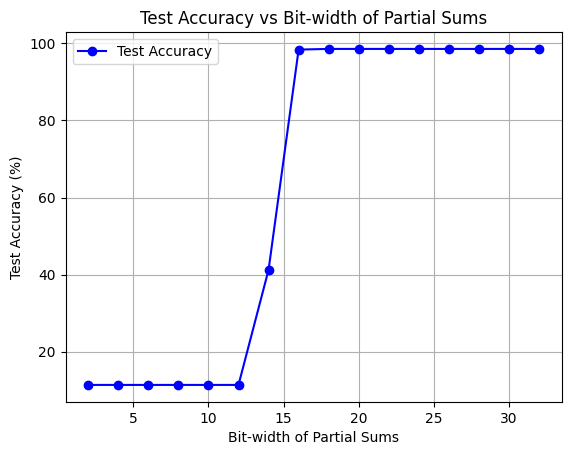

In [8]:
import matplotlib.pyplot as plt
acc = []
for i in range(1, 17):
    acc.append(run_LeNet(i*2))

# TODO
# Plot the accuracy vs bit-width

# Plotting the Test Accuracy vs Bit-width of Partial Sums
bit_widths = [i * 2 for i in range(1, 17)]  # Bit-widths in [2, 4, ..., 32]
plt.plot(bit_widths, acc, marker='o', color='b', label='Test Accuracy')

plt.xlabel("Bit-width of Partial Sums")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy vs Bit-width of Partial Sums")
plt.grid(True)
plt.legend()
plt.show()

### 2.2 Question: Find the minimum bit-width of partial sums for each layer without hurting the accuracy
1. Plot the distribution of partial sums of each quantized layer in the CNN with the MNIST test dataset and put the result in report. Write down the min, max, and standard deviation for each layer.
    * Check the TODO in `LeNet` of `functional.py`. You should save all partial sums to the dictionary, `psum_record_dict`.
    * We can get this dictionary after running the model with the first image in the test dataset by `model.psum_record_dict`.
2. Determine the minimum bit-width of partial sums in each layer without hurting the accuracy.
    * Fill in the TODO to see if the accuracy is still the same.
    * Show the accuracy in the report after doing so.

bit: 32
bit-width range: (-2147483648, 2147483647)


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py:7096: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


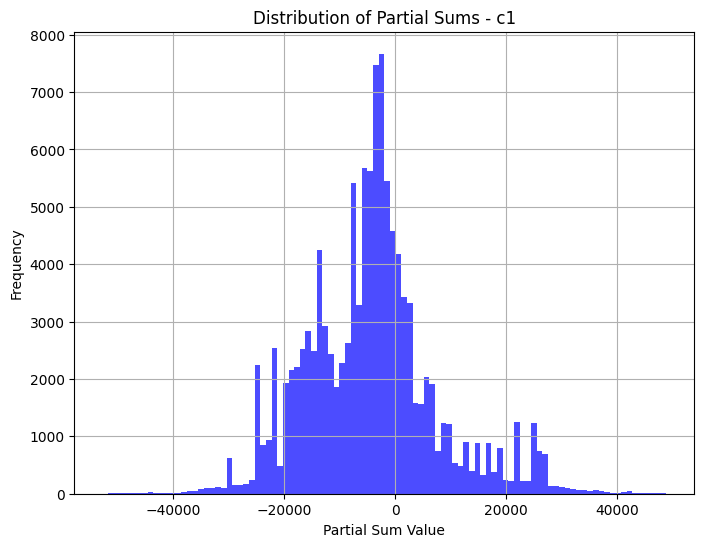

Layer: c1
Min Partial Sum: (-52685.07914412022+0j)
Max Partial Sum: (48834.24036991596+0j)
Standard Deviation: 11930.041502356664
--------------------------------------------------


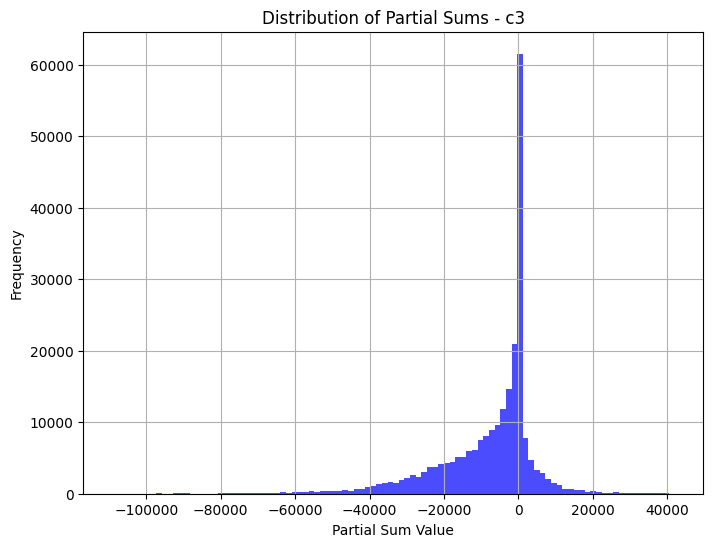

Layer: c3
Min Partial Sum: (-109360+0j)
Max Partial Sum: (42057+0j)
Standard Deviation: 13442.252068072943
--------------------------------------------------


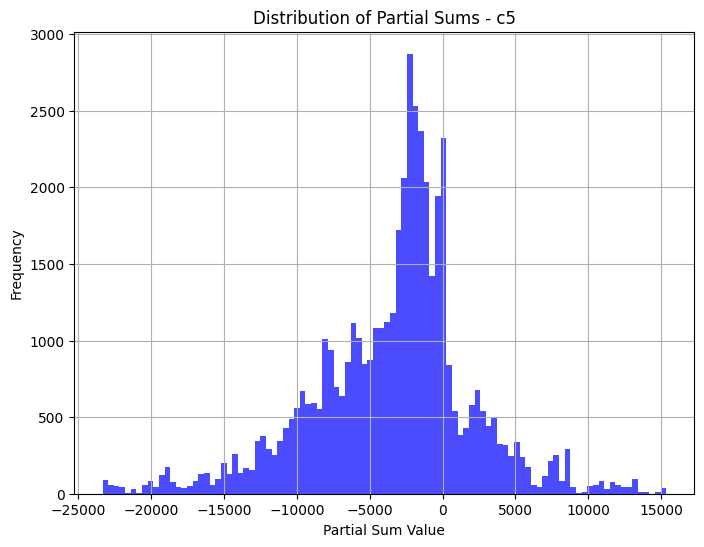

Layer: c5
Min Partial Sum: (-23325+0j)
Max Partial Sum: (15341+0j)
Standard Deviation: 5500.0661483350705
--------------------------------------------------


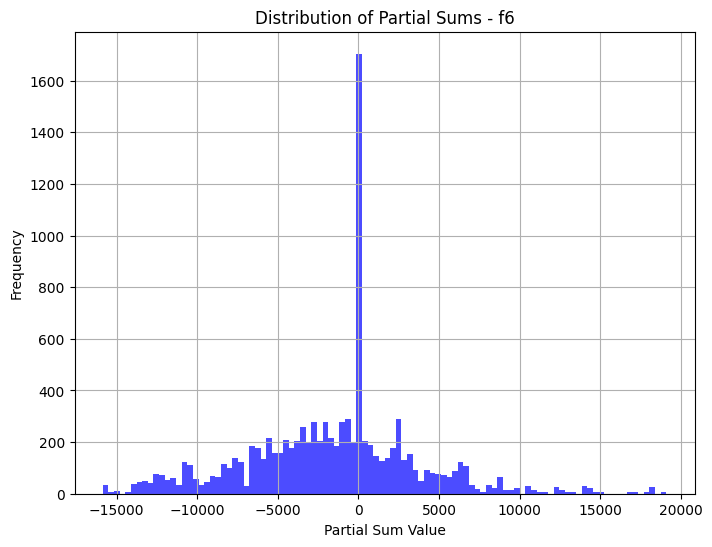

Layer: f6
Min Partial Sum: (-15866+0j)
Max Partial Sum: (19112+0j)
Standard Deviation: 5324.825414430638
--------------------------------------------------


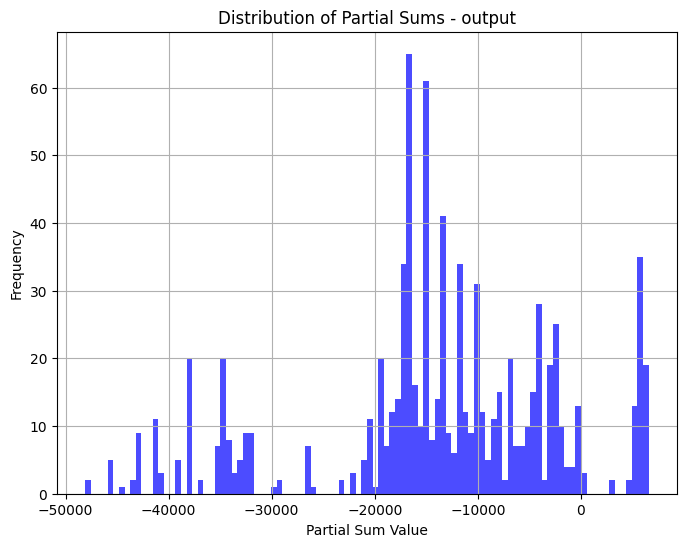

Layer: output
Min Partial Sum: (-48103+0j)
Max Partial Sum: (6569+0j)
Standard Deviation: 11984.27439163847
--------------------------------------------------


In [9]:
import matplotlib.pyplot as plt
n_bit = 32
number_range = (-(2**(n_bit-1)), 2**(n_bit-1) - 1)
print("bit:", n_bit)
print("bit-width range:",number_range)

psum_range = {
    'c1': number_range,
    'c3': number_range,
    'c5': number_range,
    'f6': number_range,
    'output': number_range
}

model = LeNet(psum_range)

image = np.expand_dims(testset[0][0], axis=0)
_ = model.forward(image, psum_record = True)

# TODO
# Plot the distribution of partial sums of each quantized layer in the CNN

# Plot the distribution of partial sums of each quantized layer
layers = ['c1', 'c3', 'c5', 'f6', 'output']
for layer in layers:
    psums = model.psum_record_dict[layer]  # Get the partial sums for the current layer

    # Flatten the list of partial sums to make it 1D for plotting
    psums = np.array(psums).flatten()

    # Plot histogram of partial sums
    plt.figure(figsize=(8, 6))
    plt.hist(psums, bins=100, range=(min(psums), max(psums)), color='blue', alpha=0.7)
    plt.title(f"Distribution of Partial Sums - {layer}")
    plt.xlabel("Partial Sum Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Print the min, max, and standard deviation of the partial sums
    print(f"Layer: {layer}")
    print(f"Min Partial Sum: {min(psums)}")
    print(f"Max Partial Sum: {max(psums)}")
    print(f"Standard Deviation: {np.std(psums)}")
    print("-" * 50)

In [11]:
# TODO
# Test your model with those Bit-widths you choose
# (-32768, 32767) 16 bit-width
# (-131072, 131071) 18 bit-width
psum_range = {
    'c1': (-131072, 131071),
    'c3': (-131072, 131071),
    'c5': (-32768, 32767),
    'f6': (-32768, 32767),
    'output': (-32768, 32767)
}

model = LeNet(psum_range)

_ = test(model, testloader)


Accuracy: 98.58%


## 3. Evaluation: Energy Model
### 3.1 Question: Evaluate these two approaches based on the following energy model:
$$E_w = s_{mul}\times N_{mul} + s_{add}\times N_{add},$$
$$s_{mul} = \alpha\times \left(\frac{B_{mul}}{8}\right)^2,\ \alpha = 64,$$
$$s_{add} = \beta\times B_{add}, \ \beta=1,$$
The variables $N_{mul}$ and $N_{add}$ represent the number of multiplications and additions in your dataflow, respectively. It's possible to calculate the $N_{mul}$ and $N_{add}$ of each layer by hand. The variables $B_{mul}$ and $B_{add}$ denote the bit-widths of multiplier and adder, respectively. The constants α and β are provided to model the energy scaling factor of multiplication and addition, respectively. Additionally, $s_{mul}$ represents the energy cost per multiplication, which is proportional to the square of the multiplier’s bit-width. On the other hand, $s_{add}$ denotes the energy cost per addition, which is linearly proportional to the adder’s bit-width. For instance, in our estimation model, a 4-bit multiplier has an energy cost per multiplication of 16, which is computed as 64 x (4/8)^2.
* You must accumulate the energy layer by layer to obtain the overall $E_w$, if each layer has a  different $B_{mul}$ or $B_{add}$.
* We only consider convolution and fully-connected operations, ignoring pooling and ReLU operations in this energy model.
* Disclaimer: Note that this energy model is artificial and oversimplified. DO NOT apply it to your research work.

1. Calculate the overall $E_w$ with minimum bit-width for the setup of 2.1.
2. Calculate the energy layer by layer and also the overall $E_w$ for the setup of 2.2.